In [170]:
import numpy as np 
from numpy import random
import pandas as pd 
from collections import deque
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pygame 
import time 
import os
import pickle


In [171]:
class Maze:
    def __init__(self,grid):
        self.grid=grid
        self.n_actions=4
        self.actions=[0,1,2,3]
        self.cell_size = 40  
        self.width = len(grid[0])
        self.height = len(grid)
        self.screen = None
       
    def initialize_display(self):
        pygame.init()
        self.screen = pygame.display.set_mode((self.width * self.cell_size, self.height * self.cell_size))
        pygame.display.set_caption("Trained DQN Maze")
        self.clock = pygame.time.Clock()
    def render(self):
        if self.screen is None:
            self.initialize_display()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()

        colors = {
            0: (255, 255, 255),  
            1: (0, 0, 0),        
        }
        agent_color = (0, 255, 0)
        death_eater_color = (255, 0, 0)
        goal_color = (0, 0, 255)

      
        for x in range(self.height):
            for y in range(self.width):
                color = colors[self.grid[x][y]]
                pygame.draw.rect(
                    self.screen,
                    color,
                    pygame.Rect(y * self.cell_size, x * self.cell_size, self.cell_size, self.cell_size)
                )

       
        ax, ay = self.state[0], self.state[1]
        pygame.draw.rect(self.screen, agent_color,
                        pygame.Rect(ay * self.cell_size, ax * self.cell_size, self.cell_size, self.cell_size))

        
        dx, dy = self.state[2], self.state[3]
        pygame.draw.rect(self.screen, death_eater_color,
                        pygame.Rect(dy * self.cell_size, dx * self.cell_size, self.cell_size, self.cell_size))

     
        gx, gy = self.state[4], self.state[5]
        pygame.draw.rect(self.screen, goal_color,
                        pygame.Rect(gy * self.cell_size, gx * self.cell_size, self.cell_size, self.cell_size))

        pygame.display.flip()
        
    def initial_state(self):
        while 1 :
            x1=random.randint(0,9)
            y1=random.randint(0,14)
            if(self.grid[x1][y1]!=1):
                break
        while 1 :
            x2=random.randint(0,9)
            y2=random.randint(0,14)
            if(self.grid[x2][y2]!=1):
                break
        while 1 :
            x=random.randint(0,9)
            y=random.randint(0,14)
            if(self.grid[x][y]!=1):
                break
        self.state=[x1,y1,x2,y2,x,y]
        return self.state
    def death_eater(self):
        visited=set()
        start = (self.state[2], self.state[3])  
        goal = (self.state[0], self.state[1])  
        queue = deque()
        parent = {}
        queue.append(start)
        visited.add(start)
        
        while queue:
            curr = queue.popleft()
            if curr == goal:
                break
            for dx, dy, a in [(-1, 0, 0), (1, 0, 1), (0, -1, 2), (0, 1, 3)]:
                nx, ny = curr[0] + dx, curr[1] + dy
                if 0 <= nx < 10 and 0 <= ny < 15 and self.grid[nx][ny] != 1 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    parent[(nx, ny)] = (curr, a)
                    queue.append((nx, ny))
        
        if goal not in parent:
            return -1  

      
        node = goal
        while parent[node][0] != start:
            node = parent[node][0]
        return parent[node][1] 

    def death_eater_action(self):
        action=self.death_eater()
        if action==-1:
            return False,self.state[2],self.state[3]
        done=False
        x,y=self.state[2],self.state[3]
        next_state_x=x
        next_state_y=y
        if action==0 and x!=0 and self.grid[x-1][y]!=1:
            if(x-1==self.state[0] and y==self.state[1]):
                done=True
            next_state_x=x-1
            next_state_y=y
        elif action==1 and x!=9 and self.grid[x+1][y]!=1:
            if(x+1==self.state[0] and y==self.state[1]):
                done=True
            next_state_x=x+1
            next_state_y=y
        elif action==2 and y!=0 and self.grid[x][y-1]!=1:
            if(x==self.state[0] and y-1==self.state[1]):
                done=True
            next_state_x=x
            next_state_y=y-1
        elif action==3 and y!=14 and self.grid[x][y+1]!=1:
            if(x==self.state[0] and y+1==self.state[1]):
                done=True
            next_state_x=x
            next_state_y=y+1
        self.state[2]=next_state_x
        self.state[3]=next_state_y
        return done,next_state_x,next_state_y
    def action_(self,action):
        reward=0
        done=False
        x,y=self.state[0],self.state[1]
        next_state_x=x
        next_state_y=y
        if action==0 and x!=0 and self.grid[x-1][y]!=1:
            if(x-1==self.state[4] and y==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x-1
            next_state_y=y
        elif action==1 and x!=9 and self.grid[x+1][y]!=1:
            if(x+1==self.state[4] and y==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x+1
            next_state_y=y
        elif action==2 and y!=0 and self.grid[x][y-1]!=1:
            if(x==self.state[4] and y-1==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x
            next_state_y=y-1
        elif action==3 and y!=14 and self.grid[x][y+1]!=1:
            if(x==self.state[4] and y+1==self.state[5]):
                reward=100
                done=True
            else:
                reward=0
            next_state_x=x
            next_state_y=y+1
        else:
            reward=0
        self.state[0]=next_state_x
        self.state[1]=next_state_y
        if(next_state_x==self.state[2] and next_state_y==self.state[3]):
            done=True
            reward=-10
        
        return reward,done,next_state_x,next_state_y


        

In [172]:
def action_harry(epsilon,Q,state):
    if random.random()<epsilon:
        return random.randint(0,3)
    else:
        return np.argmax(Q[state[0]][state[1]][state[2]][state[3]][state[4]][state[5]])


In [ ]:
def clamp(val, min_val, max_val):
    return max(min_val, min(val, max_val - 1))
def running(episodes,Q,grid):
    epsilon=1
    min_epsilon=0.01
    gamma=0.9
    alpha=0.8
    env=Maze(grid)
    rewards=[]
    success=[]
    for i in range(episodes):
        state=env.initial_state()
        done=False
        steps=0
        max_steps=300
        reward_ep=0
        success_ep=0
        while not done and steps<=max_steps:
            env.render()
            time.sleep(0.2)
            steps+=1
            action=action_harry(epsilon,Q,state)
            reward,done1,x1,y1=env.action_(action)
            done2,x2,y2=env.death_eater_action()
            x1 = clamp(x1, 0, 10)
            y1 = clamp(y1, 0, 15)
            x2 = clamp(x2, 0, 10)
            y2 = clamp(y2, 0, 15)
            done=done1 or done2
            if done2 == True:
                reward=-10
            Q[state[0]][state[1]][state[2]][state[3]][state[4]][state[5]][action]=Q[state[0]][state[1]][state[2]][state[3]][state[4]][state[5]][action]+alpha*(reward+np.max(Q[x1][y1][x2][y2][state[4]][state[5]])-Q[state[0]][state[1]][state[2]][state[3]][state[4]][state[5]][action])
            state=[x1,y1,x2,y2,state[4],state[5]]
            if done1==True:
                success_ep=1
            reward_ep+=reward
        epsilon = max(0.01, epsilon * 0.99)

        success.append(success_ep)
        rewards.append(reward_ep)
    return success,rewards,Q

shape = (10, 15, 10, 15, 10, 15, 4)
Q = np.zeros(shape)
grid = [
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,0,1,1,0,1,0,1,0,1,1,0,0,0,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,0,1,0,0,1,1,0,1,1,0,0,1,0,1],
    [1,0,0,0,1,0,0,1,0,1,0,1,0,1,1],
    [1,0,0,0,1,0,0,0,0,0,0,0,1,0,1],
    [1,0,1,0,0,1,1,0,1,0,0,0,0,0,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
    [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
]
if os.path.exists("q_table.pkl"):
    with open("q_table.pkl", "rb") as f:
        Q = pickle.load(f)
        
episodes=10000
success,rewards,Q=running(episodes,Q,grid)
with open("q_table.pkl", "wb") as f:
    pickle.dump(Q, f)
c=0
for i in range(episodes):
    if(success[i]==1):
        c+=1
print(f'Success Rate : {c*100/episodes}%')


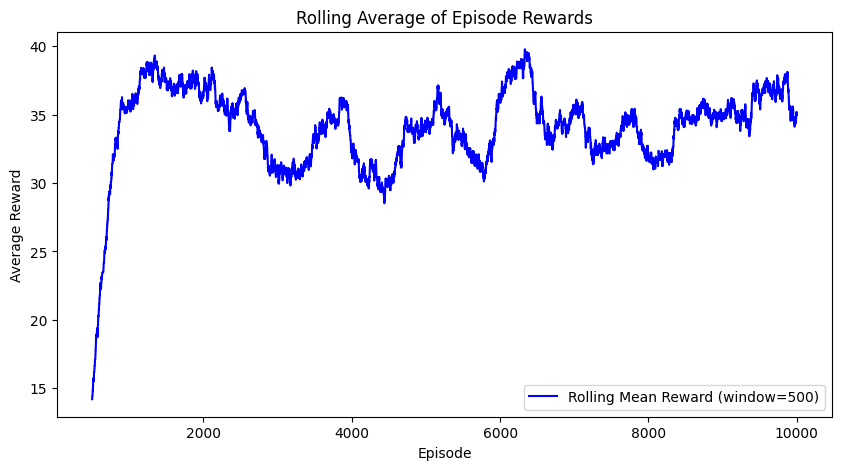

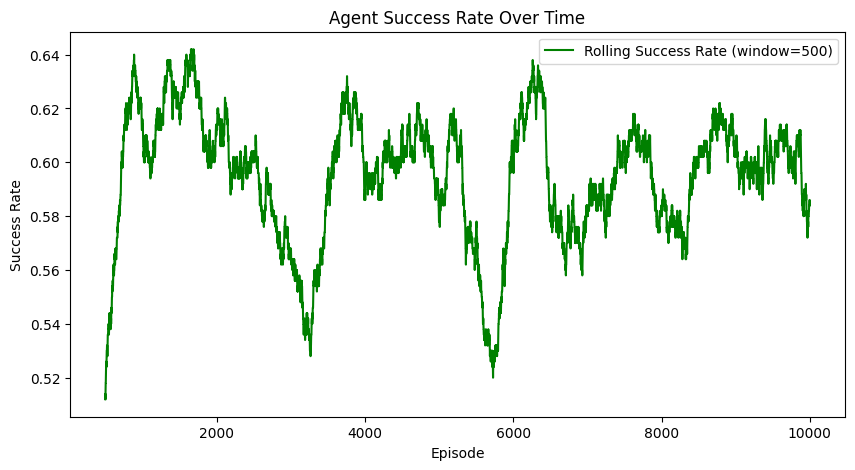

In [ ]:
rewards_series = pd.Series(rewards)


rolling_mean = rewards_series.rolling(window=500).mean()


plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, label="Rolling Mean Reward (window=500)", color='blue')
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("Rolling Average of Episode Rewards")
plt.legend()
plt.show()

window_size = 500
rolling_success = pd.Series(success).rolling(window=window_size).mean()

plt.figure(figsize=(10, 5))
plt.plot(rolling_success, label=f"Rolling Success Rate (window={window_size})", color="green")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.title("Agent Success Rate Over Time")
plt.legend()
plt.show()